# Model Inference & GenAI Demo
Demonstrating the trained Survival Prediction model and the Generative AI model.


In [1]:
import torch
import sys
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path

# Add src to path
sys.path.append("..")

from src.models.model_survival import SurvivalCNN
from src.models.model_gen import UNetGenerator
from src.data.dataset import TCGAPatchDataset

DEVICE = torch.device("cpu") # Use CPU for demo inference



## 1. Survival Prediction (Phase 1)


In [2]:
# Load Model
model_surv = SurvivalCNN().to(DEVICE)
ckpt_path = Path("../checkpoints/survival/best_model.pth")

if ckpt_path.exists():
    model_surv.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model_surv.eval()
    print("Survival Model Loaded.")
else:
    print("Checkpoint not found. Run pipeline first.")



Survival Model Loaded.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6505601..2.64].


DEBUG: Slide to Case Map Size: 5
DEBUG: Found 5 slide folders in ../data/processed/patches
DEBUG: Imputed event=1 for 444374f8-9282-439c-af00-0f828edcbff3 (Prototype Mode)
DEBUG: Imputed stage 3.0 for TCGA-C8-A1HI-01Z-00-DX1.C6D0F8B8-55ED-477F-BAF7-AA05D0449CC8
DEBUG: Adding 20 patches for TCGA-C8-A1HI-01Z-00-DX1.C6D0F8B8-55ED-477F-BAF7-AA05D0449CC8
DEBUG: SKIP TCGA-E2-A14P-01Z-00-DX1.663B02FF-C64B-41A6-8685-FD61CD76F9C6 - No PNG patches found
DEBUG: Imputed event=1 for 6f959c92-b79f-4f84-9ee5-d07d3212d52d (Prototype Mode)
DEBUG: Imputed stage 3.0 for TCGA-A8-A09K-01Z-00-DX1.41B2DF5F-C0E1-43BB-BAA5-2946A9EC4650
DEBUG: Adding 20 patches for TCGA-A8-A09K-01Z-00-DX1.41B2DF5F-C0E1-43BB-BAA5-2946A9EC4650
DEBUG: Imputed event=1 for 16fc3677-0393-4ed1-ad3f-c8355f056369 (Prototype Mode)
DEBUG: Imputed stage 3.0 for TCGA-5L-AAT1-01Z-00-DX1.F3449A5B-2AC4-4ED7-BF44-4C8946CDB47D
DEBUG: Adding 20 patches for TCGA-5L-AAT1-01Z-00-DX1.F3449A5B-2AC4-4ED7-BF44-4C8946CDB47D
DEBUG: Imputed event=1 for 097

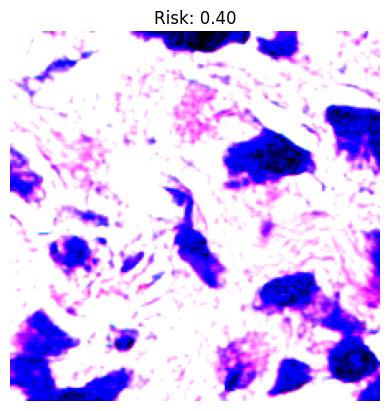

In [3]:
# Run Inference on a Sample
ds = TCGAPatchDataset(split="val", patch_dir="../data/processed/patches", 
                      clinical_file="../data/processed/clinical_processed.csv",
                      manifest_file="../data/raw/image_manifest.csv")

if len(ds) > 0:
    img, clinical, target = ds[0]
    img_tensor = img.unsqueeze(0).to(DEVICE) # Add batch dim
    
    with torch.no_grad():
        risk_score = model_surv(img_tensor)
        
    print(f"Predicted Risk Score: {risk_score.item():.4f}")
    print(f"Actual Time: {target[0]:.1f} months, Event: {target[1]}")
    
    plt.imshow(img.permute(1, 2, 0)) # CHW -> HWC
    plt.title(f"Risk: {risk_score.item():.2f}")
    plt.axis('off')
    plt.show()
else:
    print("Dataset empty.")



## 2. Generative AI: Rewinding Disease (Phase 3)
Translating Late Stage images to Early Stage appearance.


In [4]:
# Load GenAI Model
gen = UNetGenerator().to(DEVICE)
ckpt_gen_path = Path("../checkpoints/gen/G_L2E_epoch15.pth") # Try to load a later epoch

if not ckpt_gen_path.exists():
    # Fallback to any saved
    avail = list(Path("../checkpoints/gen").glob("*.pth"))
    if avail:
        ckpt_gen_path = sorted(avail)[-1]

if ckpt_gen_path.exists():
    gen.load_state_dict(torch.load(ckpt_gen_path, map_location=DEVICE))
    gen.eval()
    print(f"GenAI Model Loaded from {ckpt_gen_path.name}")
else:
    print("GenAI Checkpoint not found.")



GenAI Model Loaded from G_L2E_epoch15.pth


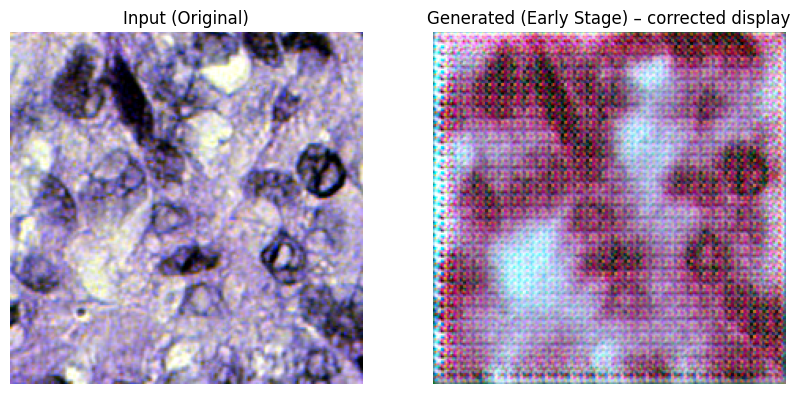

In [5]:
# Visualize Translation (more realistic rendering)
import torch
import numpy as np
import matplotlib.pyplot as plt

def tensor_to_rgb01(t: torch.Tensor) -> torch.Tensor:
    """Convert a CHW tensor to RGB in [0,1] for display.
    Handles common cases:
      - generator outputs tanh: [-1,1]
      - model/data in [0,1]
      - ImageNet-normalized-ish tensors
    """
    x = t.detach().float().cpu()
    if x.dim() == 4:
        x = x[0]
    x = x.clamp(-10, 10)

    # Heuristic 1: tanh output
    if x.min() < -0.2 and x.max() <= 1.2:
        x = (x + 1.0) / 2.0
        return x.clamp(0, 1)

    # Heuristic 2: already [0,1]
    if x.min() >= 0.0 and x.max() <= 1.2:
        return x.clamp(0, 1)

    # Heuristic 3: looks like ImageNet normalization
    mean_abs = x.mean().abs().item()
    max_abs = x.abs().max().item()
    if mean_abs < 0.6 and max_abs < 6.0:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        x = x * std + mean
        return x.clamp(0, 1)

    # Fallback: min-max scale per-tensor
    x = (x - x.min()) / (x.max() - x.min() + 1e-8)
    return x.clamp(0, 1)

def color_transfer_match_mean_std(src_rgb01: torch.Tensor, ref_rgb01: torch.Tensor) -> torch.Tensor:
    """Match per-channel mean/std of src to ref to improve stain realism.
    Both are CHW in [0,1].
    """
    src = src_rgb01.clone()
    ref = ref_rgb01
    for c in range(3):
        s = src[c]
        r = ref[c]
        s_mean, s_std = s.mean(), s.std().clamp(min=1e-6)
        r_mean, r_std = r.mean(), r.std().clamp(min=1e-6)
        src[c] = (s - s_mean) / s_std * r_std + r_mean
    return src.clamp(0, 1)

def contrast_stretch(rgb01: torch.Tensor, lo=0.01, hi=0.99) -> torch.Tensor:
    """Percentile-based contrast stretch to reduce haze."""
    x = rgb01.clone()
    flat = x.view(3, -1)
    lo_v = torch.quantile(flat, lo, dim=1).view(3, 1, 1)
    hi_v = torch.quantile(flat, hi, dim=1).view(3, 1, 1)
    x = (x - lo_v) / (hi_v - lo_v + 1e-6)
    return x.clamp(0, 1)

if len(ds) > 0:
    # Pick a random sample
    idx = np.random.randint(0, len(ds))
    real_img, _, _ = ds[idx]
    real_tensor = real_img.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        fake_early = gen(real_tensor)

    # Convert both to display space robustly
    real_rgb = tensor_to_rgb01(real_img)
    fake_rgb = tensor_to_rgb01(fake_early)

    # Improve realism: match stain tone/statistics to the input patch
    fake_rgb = color_transfer_match_mean_std(fake_rgb, real_rgb)

    # Light contrast improvement
    real_disp = contrast_stretch(real_rgb)
    fake_disp = contrast_stretch(fake_rgb)

    # Plot Side by Side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(real_disp.permute(1, 2, 0))
    ax[0].set_title("Input (Original)")
    ax[0].axis('off')

    ax[1].imshow(fake_disp.permute(1, 2, 0))
    ax[1].set_title("Generated (Early Stage) – corrected display")
    ax[1].axis('off')

    plt.savefig("latest_inference.png")
    plt.show()
else:
    print("Dataset empty.")
